# CRISP DM


# Problem Understanding:
A central step in the ORCA pipeline is the automated mapping of natural language threat
descriptions to structured attack patterns from the Common Attack Pattern Enumeration
and Classification (CAPEC) framework. This process—referred to as Threat-to-CAPEC
Mapping—aims to translate unstructured textual threat inputs into standardized, machine-
readable representations that describe how an attacker might exploit a given vulnerability.
This mapping is critical for enabling further steps in the security analysis process, such
as correlating threats with known vulnerabilities (CWEs, CVEs), assessing risk using
scoring systems like CVSS, and informing mitigation strategies. However, the task poses
several inherent challenges:
Ambiguity: Threat descriptions are often informal, incomplete, or context-dependent.
Terminology mismatch: Natural language inputs may not directly align with the technical
vocabulary used in CAPEC definitions.
Granularity: A single threat may correspond to multiple CAPECs at varying levels of
abstraction, requiring semantic reasoning to determine relevance.
Solving this problem involves designing a system capable of understanding the semantics
of threat descriptions and reliably identifying the most appropriate CAPEC entries. This
step must balance accuracy, scalability, and interpretability to support reliable, automated
security assessments within the broader ORCA framework.

# Data Understanding

In [1]:
# imports
import pandas as pd
import json
import re
import time
import ollama
from IPython.display import HTML, display
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

from sentence_transformers import SentenceTransformer, util
import torch
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

import pprint
from pprint import pprint

from tqdm import tqdm
from google import genai
from google.genai import types

from pprint import pprint

from IPython.display import HTML, Markdown, display

display(HTML('''
<style>
/* White background for output area */
.output_area {
    background: white !important;
    color: black !important;
}

/* Optional: White background for DataFrame cells */
.dataframe {
    background-color: white !important;
    color: black !important;
}
</style>
'''))



/root/MasterThesis_LLM_optimization_ORCA/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Import threat data from json file

In [3]:
# Load threat data from JSON file into a DataFrame
df_threats = pd.read_json('threat_data/all_threats.json')
df_threats.head(5)

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
0,T-O-RAN-01,An attacker exploits insecure designs or lack of adaption in O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",None,None,All,"[Outdated component from the lack of update or patch management, Poorly design architecture, Missing appropriate security hardening, Unnecessary or insecure function/protocol/component]",All,All
1,T-O-RAN-02,An attacker exploits misconfigured or poorly configured O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.",None,None,All,"[Errors from the lack of configuration change management, Misconfigured or poorly configured O-RAN components, Improperly configured permissions, Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges), Default accounts and their passwords still enabled and unchanged, Security features are disabled or not configured securely]",All,All
2,T-O-RAN-03,Attacks from the internet to penetrate O-RAN network boundary,"Web servers serving O-RAN functional and management services should provide adequate protection. \nAn attacker that have access to the uncontrolled O-RAN network could:\n• Bypass the information flow control policy implemented by the firewall,\n• And/or attack O-RAN components in the trusted networks by taking advantage of particularities and errors in the design and implementation of the network protocols (IP, TCP, UDP, application protocols),\n• Use of incorrect or exceeded TCP sequence numbers,\n• Perform brute force attacks on FTP passwords,\n• Use of improper HTTP user sessions,\n• Etc.\nThe effects of such attacks may include:\n• An intrusion, 

In [4]:
# Display DataFrame information
df_threats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Threat ID            182 non-null    object
 1   Threat title         182 non-null    object
 2   Threat Description   182 non-null    object
 3   Threat type          82 non-null     object
 4   Impact type          82 non-null     object
 5   Threat agent         182 non-null    object
 6   Vulnerability        182 non-null    object
 7   Threatened Asset     182 non-null    object
 8   Affected Components  182 non-null    object
dtypes: object(9)
memory usage: 12.9+ KB


There a 182 threats in 9 columns, each threat has a unique ID, a title, a description, a threat type, an impact type, a threat agent, one or more vulnerabilities (safed in a list), a threatened asset and a affected component

In [5]:
df_threats.describe()

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
count,182,182,182,82,82,182,182,182,182
unique,182,181,182,16,17,2,116,58,55
top,T-O-RAN-01,External attacker exploits authentication weakness on SMO,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",Spoofing,Authenticity,All,[weak mutual authentication],"ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-20, ASSET-D-29, ASSET-D-31, ASSET-D-32",All
freq,1,2,1,28,26,178,12,24,19


In [6]:
df_threats.isnull().sum()

Threat ID                0
Threat title             0
Threat Description       0
Threat type            100
Impact type            100
Threat agent             0
Vulnerability            0
Threatened Asset         0
Affected Components      0
dtype: int64

In [7]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

In [8]:
df_threats.groupby('Threat type').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,Threat type,count
0,Spoofing,28
1,Denial of Service,11
2,Elevation of Privilege,10
3,Information Disclosure,9
4,Tampering,8
5,Information disclosure,4
6,Tampering; Denial of Service,2
7,"Elevation of Privilege, Information Disclosure",2
8,Elevation of Privilege; Denial of Service,1
9,"Denial of Service, Escalation of Privilege",1


In [9]:
(df_threats['Threat type'].isnull() == df_threats['Impact type'].isnull()).all()


np.True_

In [10]:
df_threats['Threat type'].value_counts(dropna=False)

Threat type
None                                                          52
NaN                                                           48
Spoofing                                                      28
Denial of Service                                             11
Elevation of Privilege                                        10
Information Disclosure                                         9
Tampering                                                      8
Information disclosure                                         4
Elevation of Privilege, Information Disclosure                 2
Tampering; Denial of Service                                   2
Information disclosure, Tampering                              1
Tampering, Information Disclosure, Escalation of Privilege     1
Denial of Service, Escalation of Privilege                     1
Denial of Service; Tampering                                   1
Elevation of Privilege; Denial of Service                      1
Tampering; El

In [11]:
df_threats['Impact type'].value_counts(dropna=False)

Impact type
None                                         52
NaN                                          48
Authenticity                                 26
Confidentiality                              14
Availability                                 12
Authorization                                 9
Integrity                                     7
Authentication                                2
Integrity; Availability                       2
Authorization. Confidentiality                1
Integrity, Confidentiality, Authorization     1
Availability; Integrity                       1
Confidentiality, Integrity                    1
Authorization; Availability                   1
Integrity; Authorization; Availability        1
Integrity, Availability                       1
Availability, Confidentiality                 1
Confidentiality, Availability                 1
Authorization, Availability                   1
Name: count, dtype: int64

In [12]:
df_threats['Vulnerability'].value_counts(dropna=False)

Vulnerability
[weak mutual authentication]                                                                                                                                                                                                                                                     12
[Weak authentication can be exploited by a tenant to move laterally across the deployment.]                                                                                                                                                                                       9
[Lack of integrity verification]                                                                                                                                                                                                                                                  5
[Lack of overload protection and rate-limiting]                                                                                                               

## Distribution Analysis


In [13]:
# some threat types as well as impact types are seperated by a comma, while others are seperated by a semicolon or a point
# Replace all semicolons with commas
df_threats['Threat type'] = df_threats['Threat type'].str.replace(';', ',', regex=False)
df_threats['Threat type'] = df_threats['Threat type'].str.replace('.', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace(';', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace('.', ',', regex=False)
# in the Threatened asssets column, some values have a underscore instead of a dash
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].str.replace('_', '-', regex=False)

In [14]:
# removing leading and trailing whitespace from the 'Threat type','Impact type','Threatened asset' and 'Affected components' columns
df_threats['Threat type'] = df_threats['Threat type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Impact type'] = df_threats['Impact type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Affected Components'] = df_threats['Affected Components'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
# the vulnerability column contains a list with only one string element
# this string contains multpile vulnerabilities separated by commas
# we convert the list to this one string element and then split the string by commas
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(lambda x: x[0] if isinstance(x, list) else x)
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)

In [15]:
# the 'Threatened Asset' column contains values like 'All' or 'ASSET-D-33 to ASSET-D-38', we solve this by manually turning this into the correct list


# Example: start from your DataFrame
# df_threats = pd.read_json(...)  # or however you're loading it

# Step 1: Drop NaNs
asset_entries = df_threats['Threatened Asset'].dropna()

# Step 2: Function to expand ranges like 'ASSET-D-33 to ASSET-D-38'
def expand_range(entry):
    match = re.match(r"(ASSET-[A-Z]-)(\d+)\s+to\s+ASSET-[A-Z]-(\d+)", entry.strip())
    if match:
        prefix, start, end = match.groups()
        return [f"{prefix}{i}" for i in range(int(start), int(end) + 1)]
    return [entry.strip()]

# Step 3: Build the set of unique assets
all_assets = set()

for entry in asset_entries:
    # If entry is a list, turn it into a string
    if isinstance(entry, list):
        entry = ', '.join(entry)
    
    # Ensure it's a string before splitting
    if isinstance(entry, str):
        parts = [p.strip() for p in entry.split(',')]
        for part in parts:
            if part.lower() == 'all':
                continue  # or expand to full known asset list if desired
            elif 'to' in part:
                expanded = expand_range(part)
                all_assets.update(expanded)
            else:
                all_assets.add(part.strip())

# Step 4: Show all unique asset names sorted
all_assets = sorted(all_assets)
pprint(all_assets)




['ASSET D-11',
 'ASSET D-20',
 'ASSET D-21',
 'ASSET-C-02',
 'ASSET-C-03',
 'ASSET-C-07',
 'ASSET-C-08',
 'ASSET-C-09',
 'ASSET-C-1',
 'ASSET-C-10',
 'ASSET-C-11',
 'ASSET-C-12',
 'ASSET-C-14',
 'ASSET-C-16',
 'ASSET-C-17',
 'ASSET-C-18',
 'ASSET-C-19',
 'ASSET-C-2',
 'ASSET-C-20',
 'ASSET-C-21',
 'ASSET-C-22',
 'ASSET-C-23',
 'ASSET-C-24',
 'ASSET-C-25',
 'ASSET-C-26',
 'ASSET-C-27',
 'ASSET-C-28',
 'ASSET-C-3',
 'ASSET-C-31',
 'ASSET-C-32',
 'ASSET-C-33',
 'ASSET-C-34',
 'ASSET-C-35',
 'ASSET-C-36',
 'ASSET-C-37',
 'ASSET-C-38',
 'ASSET-C-39',
 'ASSET-C-4',
 'ASSET-C-40',
 'ASSET-C-42',
 'ASSET-C-5',
 'ASSET-C-6',
 'ASSET-C-7',
 'ASSET-C-8',
 'ASSET-C-9',
 'ASSET-D-01',
 'ASSET-D-02',
 'ASSET-D-03',
 'ASSET-D-04',
 'ASSET-D-05',
 'ASSET-D-06',
 'ASSET-D-07',
 'ASSET-D-08',
 'ASSET-D-09',
 'ASSET-D-1',
 'ASSET-D-10',
 'ASSET-D-11',
 'ASSET-D-12',
 'ASSET-D-13',
 'ASSET-D-14',
 'ASSET-D-15',
 'ASSET-D-16',
 'ASSET-D-17',
 'ASSET-D-18',
 'ASSET-D-19',
 'ASSET-D-2',
 'ASSET-D-20',
 'ASSE

In [16]:
def normalize_assets(value):
    # Convert list to string if needed
    if isinstance(value, list):
        value = ', '.join(value)
    
    if isinstance(value, str):
        value = value.strip()
        if value.lower() == 'all':
            return all_assets
        elif 'to' in value:
            return expand_range(value)
        else:
            # handle comma-separated list like 'ASSET-D-15, ASSET-C-17'
            return [v.strip() for v in value.split(',')]
    
    return value  # leave as-is if unexpected

df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(normalize_assets)



In [17]:
df_threats['Threatened Asset'].head(20)

0     [ASSET D-11, ASSET D-20, ASSET D-21, ASSET-C-02, ASSET-C-03, ASSET-C-07, ASSET-C-08, ASSET-C-09, ASSET-C-1, ASSET-C-10, ASSET-C-11, ASSET-C-12, ASSET-C-14, ASSET-C-16, ASSET-C-17, ASSET-C-18, ASSET-C-19, ASSET-C-2, ASSET-C-20, ASSET-C-21, ASSET-C-22, ASSET-C-23, ASSET-C-24, ASSET-C-25, ASSET-C-26, ASSET-C-27, ASSET-C-28, ASSET-C-3, ASSET-C-31, ASSET-C-32, ASSET-C-33, ASSET-C-34, ASSET-C-35, ASSET-C-36, ASSET-C-37, ASSET-C-38, ASSET-C-39, ASSET-C-4, ASSET-C-40, ASSET-C-42, ASSET-C-5, ASSET-C-6, ASSET-C-7, ASSET-C-8, ASSET-C-9, ASSET-D-01, ASSET-D-02, ASSET-D-03, ASSET-D-04, ASSET-D-05, ASSET-D-06, ASSET-D-07, ASSET-D-08, ASSET-D-09, ASSET-D-1, ASSET-D-10, ASSET-D-11, ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-2, ASSET-D-20, ASSET-D-21, ASSET-D-22, ASSET-D-23, ASSET-D-24, ASSET-D-25, ASSET-D-26, ASSET-D-27, ASSET-D-28, ASSET-D-29, ASSET-D-3, ASSET-D-30, ASSET-D-31, ASSET-D-32, ASSET-D-33, ASSET-D-34, ASSET-D-35, ASSET-D-3

In [18]:
df_threats['Threat type'].explode().value_counts()
# The most common threat type is Spoofing, which occurs 28 times

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [19]:
df_threats['Vulnerability'].explode().str.lower().value_counts()
# The most common vulnerability is 'lack of authentication', which occurs 17 times,
# followed by 'lack of authentication' with 12 occurences.

Vulnerability
lack of authentication                                                                       17
weak mutual authentication                                                                   12
weak authentication can be exploited by a tenant to move laterally across the deployment.     9
missing or improperly configured authorization                                                6
lack of integrity verification                                                                6
                                                                                             ..
pnfs                                                                                          1
etc.                                                                                          1
operation areas                                                                               1
physical access to the open fronthaul cable network                                           1
use of pretrained public m

In [20]:
# Step 3: Explode the list so each asset appears in its own row
asset_flat = df_threats.explode('Threatened Asset')

# Step 4: Count how often each asset appears
asset_counts = asset_flat['Threatened Asset'].value_counts()
asset_counts.head(50)

Threatened Asset
ASSET-D-15    43
ASSET-C-17    41
ASSET-D-29    40
ASSET-D-18    38
ASSET-D-14    37
ASSET-C-31    35
ASSET-D-17    35
ASSET-D-16    35
ASSET-D-12    34
ASSET-D-13    34
ASSET-D-19    34
ASSET-D-20    34
ASSET-D-32    34
ASSET-D-31    33
ASSET-C-11    33
ASSET-C-18    22
ASSET-C-10    21
ASSET-C-08    19
ASSET-C-35    18
ASSET-D-01    18
ASSET-C-34    17
ASSET-C-26    17
ASSET-C-19    16
ASSET-C-16    16
ASSET-C-20    16
ASSET-C-21    16
ASSET-C-23    16
ASSET-C-09    16
ASSET-D-04    15
ASSET-D-26    15
ASSET-D-25    15
ASSET-C-37    15
ASSET-D-37    15
ASSET-D-34    15
ASSET-D-33    15
ASSET-D-36    15
ASSET-D-35    15
ASSET-D-38    15
ASSET-C-25    14
ASSET-C-36    14
ASSET-D-21    14
ASSET-D-02    14
ASSET-D-05    14
ASSET-D-27    13
ASSET-D-28    13
ASSET-D-06    13
ASSET-D-10    13
ASSET-D-22    13
ASSET-C-02    12
ASSET-D-43    12
Name: count, dtype: int64

In [21]:
df_threats['Impact type'].explode().value_counts()

Impact type
Authenticity       26
Availability       21
Confidentiality    19
Authorization      14
Integrity          14
Authentication      2
Name: count, dtype: int64

In [22]:
df_threats['Threat type'].explode().value_counts()

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [23]:
print(set(df_threats['Threat agent']))

{'All', 'All except Script kiddies'}


In [24]:
df_threats['Threat agent'].value_counts()

Threat agent
All                          178
All except Script kiddies      4
Name: count, dtype: int64

In [25]:
df_threats['Affected Components'].explode().value_counts() 

Affected Components
O-Cloud                  30
Non-RT RIC               29
Shared O-RU              26
Apps/VNFs/CNFs           22
All                      19
O-DU                     17
O-RU                     16
rApps                    16
Near-RT RIC              16
SMO                      14
xApps                    12
O-DU Tenant              10
SMO Framework            10
O-DU Host                 9
O-CU                      8
O2 interface              7
External interfaces       7
R1 interface              7
UE                        7
SMO Functions             6
ASSET-C-29                6
ASSET-C-30                6
O-CU Tenant               6
CUS-Plane                 5
Apps/VNFs/CNFs images     5
O-CU Host                 5
ASSET-C-08                3
A1 interface              3
E2 interface              3
M-Plane                   3
SMO Host                  3
SMO Tenant                3
xAPPs                     3
Y1 interface              2
O2                        2


In [26]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

## Text analysis

In [27]:
length_of_threat_descriptions = df_threats['Threat Description'].str.len()
print(length_of_threat_descriptions.describe())
print("The average character length of the threat descriptions is", length_of_threat_descriptions.mean())
# the average length og the threat descriptions is 528.2 characters

standard_deviation = length_of_threat_descriptions.std()
print("The standard deviation of the character length of the threat descriptions is", standard_deviation)

count     182.000000
mean      528.818681
std       491.740145
min        76.000000
25%       187.250000
50%       319.000000
75%       756.250000
max      2668.000000
Name: Threat Description, dtype: float64
The average character length of the threat descriptions is 528.8186813186813
The standard deviation of the character length of the threat descriptions is 491.74014505307065


In [28]:
length_of_threat_titles = df_threats['Threat title'].str.len()
print(length_of_threat_titles.describe())
print("The average character length of the threat titles is", length_of_threat_titles.mean())
print("The standard deviation of the character length of the threat titles is", length_of_threat_titles.std())

count    182.00000
mean      57.10989
std       27.82580
min       14.00000
25%       34.00000
50%       54.00000
75%       70.00000
max      148.00000
Name: Threat title, dtype: float64
The average character length of the threat titles is 57.10989010989011
The standard deviation of the character length of the threat titles is 27.825800083090165


In [29]:

print(df_threats['Threat Description'].value_counts().head(2))
print(df_threats['Threat title'].value_counts().head(2))

Threat Description
Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches

In [30]:
df_threats[df_threats['Threat title'] == 'External attacker exploits authentication weakness on SMO']


,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
42,T-SMO-01,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authentication weakness on SMO functions. If the authentication of O-RAN subjects on A1, O1, O2, and External interfaces on SMO is not supported or not properly implemented, those interfaces without proper credentials could be exploited to gain access to the SMO.",[Spoofing],[Authenticity],All,[Missing or improperly configured authentication],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"
43,T-SMO-02,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authorization weakness on SMO functions. A malicious external entity on A1, O1, O2, and External interfaces without authorization or with an incorrect access token may invoke the SMO functions. The data at rest related to that function will be leaked to the attacker. In addition, an attacker can be able to perform certain actions, e.g. disclose O-RAN sensitive information or alter O-RAN components.","[Elevation of Privilege, Information Disclosure]","[Authorization, Confidentiality]",All,[Missing or improperly configured authorization],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"


## Data understanding of CAPEC data

In [31]:
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

In [32]:
def pull_clone_gitrepo(directory, repo):
    # Check if the data direcory exists
    if not os.path.isdir(directory):
        Repo.clone_from(repo, directory)
    else:
        try:
            # Check if the data directory is actually a repositry then pull the canges
            repo = Repo(directory)
            repo.remotes.origin.pull()
        except InvalidGitRepositoryError:
            # If not then remove the folder
            shutil.rmtree(directory)
            Repo.clone_from(repo, directory)

def prepare_capecs_df():
    pull_clone_gitrepo('./data', 'https://github.com/mitre/cti')
    fs = FileSystemSource('./data/capec/2.1')
    filt = Filter('type', '=', 'attack-pattern')

    attack_patterns = fs.query([filt])

    data_array = []
    for pattern in attack_patterns:
        if not pattern.x_capec_status == "Deprecated":
            info = []
            result = [obj for obj in pattern.external_references if obj['source_name'] == "capec"]
            info.append(result[0].external_id)
            info.append(pattern.name)
            info.append(pattern.description)
            if "x_capec_domains" in pattern:
                info.append(pattern.x_capec_domains)
            else:
                info.append("not given")
            data_array.append(info)

    columns = ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain']
    df = pd.DataFrame(data_array, columns=columns)

    df['summary'] = ''
    for index, row in df.iterrows():
        if len(row['capec_domain']) > 1:
            domains_string = ". The Domains of this are: "+', '.join(row['capec_domain'])
        else:
            domains_string = ". The Domain of this is: "+row['capec_domain'][0]

        summary = 'A CAPEC with the title '+row['capec_name']+\
                    '. The description of this CAPEC is: '+row['capec_description']+\
                    domains_string
        
        df.at[index, 'summary'] = summary
    return df


In [33]:
#generate the capecs_df
#capecs_df = prepare_capecs_df()
##safe capecs data to pickle
#capecs_df.to_pickle('capec_data/capecs.pk1')

In [34]:
#load capecs data from pickle
capecs_df = pd.read_pickle('capec_data/capecs.pk1')

In [35]:
# Display general information about capecs_df
print("Shape of capecs_df:", capecs_df.shape)
print("\nColumn names:", capecs_df.columns.tolist())
print("\nMissing values per column:\n", capecs_df.isnull().sum())
print("\nData types:\n", capecs_df.dtypes)
print("\nFirst 5 rows:")
display(capecs_df.head())
print("\nSummary statistics for text length in 'capec_description':")
desc_lengths = capecs_df['capec_description'].dropna().str.len()
print(desc_lengths.describe())

Shape of capecs_df: (559, 5)

Column names: ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain', 'summary']

Missing values per column:
 CAPEC ID             0
capec_name           0
capec_description    0
capec_domain         0
summary              0
dtype: int64

Data types:
 CAPEC ID             object
capec_name           object
capec_description    object
capec_domain         object
summary              object
dtype: object

First 5 rows:


,CAPEC ID,capec_name,capec_description,capec_domain,summary
0,CAPEC-87,Forceful Browsing,"An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.",[Software],"A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
1,CAPEC-391,Bypassing Physical Locks,"An attacker uses techniques and methods to bypass physical security measures of a building or facility. Physical locks may range from traditional lock and key mechanisms, cable locks used to secure laptops or servers, locks on server cases, or other such devices. Techniques such as lock bumping, lock forcing via snap guns, or lock picking can be employed to bypass those locks and gain access to the facilities or devices they protect, although stealth, evidence of tampering, and the integrity of the lock following an attack, are considerations that may determine the method employed. Physical locks are limited by the complexity of the locking mechanism. While some locks may offer protections such as shock resistant foam to prevent bumping or lock forcing methods, many commonly employed locks offer no such countermeasures.",[Physical Security],"A CAPEC with the title Bypassing Physical Locks. The description of this CAPEC is: An attacker uses techniques and methods to bypass physical security measures of a building or facility. Physical locks may range from traditional lock and key mechanisms, cable locks used to secure laptops or servers, locks on server cases, or other such devices. Techniques such as lock bumping, lock forcing via snap guns, or lock picking can be employed to bypass those locks and gain access to the facilities or devices they protect, although stealth, evidence of tampering, and the integrity of the lock following an attack, are considerations that may determine the method employed. Physical locks are limited by the complexity of the locking mechanism. While some locks may offer protections such as shock resistant foam to prevent bumping or lock forcing methods, many commonly employed locks offer no such countermeasures.. The Domain of this is: Physical Security"
2,CAPEC-4,Using Alternative IP Address Encodings,"This attack relies on the adversary using unexpected formats for representing IP addresses. Networked applications may expect network location information in a specific format, such as fully qualified domains names (FQDNs), URL, IP address, or IP Address ranges. If the location information is not validated against a variety of different possible encodings and formats, the adversary can use an alternate format to bypass application access control.",[Software],"A CAPEC with the title Using Alternative IP Address Encodings. The description of this CAPEC is: This attack relies on the adversary using unexpected formats for representing IP addresses. Networked applications may expect network location information in a specific format, such as fully qualified domains names (FQDNs), URL, IP address, or IP Address ranges. If the location information is not validated against a variety of different possible encodings and formats, the adversary can use an alternate format to bypass application access control.. The Domain of this is: Software"
3,C


Summary statistics for text length in 'capec_description':
count     559.000000
mean      474.048301
std       224.179346
min         0.000000
25%       301.500000
50%       427.000000
75%       624.000000
max      1069.000000
Name: capec_description, dtype: float64


In [36]:
# show rows with missing values in 'capec_description'
capecs_df[capecs_df['capec_description'].isnull()]

,CAPEC ID,capec_name,capec_description,capec_domain,summary


In [37]:
capecs_df[capecs_df['capec_domain'] == 'not given']

,CAPEC ID,capec_name,capec_description,capec_domain,summary
81,CAPEC-699,Eavesdropping on a Monitor,"An Adversary can eavesdrop on the content of an external monitor through the air without modifying any cable or installing software, just capturing this signal emitted by the cable or video port, with this the attacker will be able to impact the confidentiality of the data without being detected by traditional security tools",not given,"A CAPEC with the title Eavesdropping on a Monitor. The description of this CAPEC is: An Adversary can eavesdrop on the content of an external monitor through the air without modifying any cable or installing software, just capturing this signal emitted by the cable or video port, with this the attacker will be able to impact the confidentiality of the data without being detected by traditional security tools. The Domains of this are: n, o, t, , g, i, v, e, n"


In [38]:
capecs_df['capec_domain'].value_counts()

capec_domain
[Software]                                                                     287
[Communications, Software]                                                      67
[Social Engineering]                                                            30
[Software, Hardware]                                                            28
[Physical Security]                                                             15
[Communications]                                                                13
[Software, Physical Security, Hardware]                                          9
[Software, Software, Software]                                                   9
[Supply Chain, Hardware]                                                         9
[Social Engineering, Supply Chain, Software]                                     8
[Supply Chain, Physical Security, Hardware]                                      8
[Supply Chain, Software]                                                  

In [39]:
# value counts for 'capec_domain'
capecs_df['capec_domain'].explode().value_counts(dropna=False)

capec_domain
Software              490
Communications        101
Hardware               91
Social Engineering     66
Supply Chain           52
Physical Security      39
not given               1
Name: count, dtype: int64

In [40]:
duplicates = capecs_df[capecs_df['capec_domain'].apply(lambda x: len(x) != len(set(x)))]['capec_domain']

print(f"Count of rows with duplicates: {len(duplicates)}")
print(duplicates)


Count of rows with duplicates: 30
25                         [Software, Software, Software]
29                                   [Software, Software]
54                                   [Hardware, Hardware]
80                         [Software, Software, Software]
81                                              not given
86     [Social Engineering, Social Engineering, Software]
91               [Social Engineering, Social Engineering]
99                                   [Software, Software]
119                        [Software, Software, Software]
123                                  [Hardware, Hardware]
156              [Social Engineering, Social Engineering]
165                                  [Software, Software]
177                        [Software, Software, Software]
201              [Social Engineering, Social Engineering]
225                        [Software, Software, Software]
243                        [Software, Hardware, Software]
262              [Social Engineering, 

# Data Preparation

Merging title and description to match the form of the original orca pipeline.

In [41]:
threats_summary_context = {'Threat title': 'A Threat with the title ', 'Threat Description': ' and the description'}
def add_summary_to_df(input_df, coll_context, ):
    input_df['summary'] = ''
    for key, value in coll_context.items():
        input_df['summary'] +=  value + input_df[key]

In [42]:
add_summary_to_df(df_threats, threats_summary_context)
df_threats.loc[0, 'summary']  

'A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause 

Data preparation for establishing a baseline, implementing the ORCA mapping.

1. Add the embedding to the threat and to to the capec data

In [43]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

def preprocess_description(description):
    # remove patterns not semantically relevant
    pattern = r"\((http|https)\S+\)|['\[\]]+"
    description = re.sub(pattern, "", description)
    return description

def gen_embedding(description):
    if isinstance(description, str):
        description1 = description
    else:
        description1 = '\n'.join(description)
    description = preprocess_description(description1)
    return model.encode(description, convert_to_numpy=True)

def add_embedd_to_df(input_df, descryption_name):
    input_df['embedding'] = input_df[descryption_name].apply(gen_embedding)

In [44]:
# add embedding to the threats dataframe
add_embedd_to_df(df_threats, 'summary')

In [45]:
# add embedding to the capecs dataframe
#capecs_with_embeddings_df = capecs_df.copy()
#add_embedd_to_df(capecs_with_embeddings_df, 'summary')
#capecs_with_embeddings_df.to_pickle('capec_data/capecs_with_embeddings.pk1')

In [46]:
capecs_with_embeddings_df = pd.read_pickle('capec_data/capecs_with_embeddings.pk1')

2. generate the mapping of threats to capecs

In [47]:
DOMAIN = "enterprise-attack"
def gen_mapping(th_df, te_df):
    maping = pd.DataFrame()
    if 'summary' in th_df.columns:
        th_df.rename(columns={'summary': 'summary_th_df'}, inplace=True)
    if 'summary' in te_df.columns:
        te_df.rename(columns={'summary': 'summary_ca_df'}, inplace=True)

    for tec_index, row_techniques in te_df.iterrows():
        for thr_index, row_threats in th_df.iterrows():
            cosine_similarity = util.pytorch_cos_sim(torch.from_numpy(row_techniques['embedding']),
                                                     torch.from_numpy(row_threats['embedding']))
            comb = pd.concat([row_techniques, row_threats], axis=0)
            comb = comb.to_frame().T
            comb['Similarity'] = cosine_similarity
            maping = pd.concat([maping, comb], ignore_index=True)

    maping['Domain'] = DOMAIN
    return maping

In [48]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components', 'summary', 'embedding'],
      dtype='object')

In [49]:
df_threats.head(1)

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components,summary,embedding
0,T-O-RAN-01,An attacker exploits insecure designs or lack of adaption in O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",None,None,All,[Outdated component from the lack of update or patch management],"[ASSET D-11, ASSET D-20, ASSET D-21, ASSET-C-02, ASSET-C-03, ASSET-C-07, ASSET-C-08, ASSET-C-09, ASSET-C-1, ASSET-C-10, ASSET-C-11, ASSET-C-12, ASSET-C-14, ASSET-C-16, ASSET-C-17, ASSET-C-18, ASSET-C-19, ASSET-C-2, ASSET-C-20, ASSET-C-21, ASSET-C-22, ASSET-C-23, ASSET-C-24, ASSET-C-25, ASSET-C-26, ASSET-C-27, ASSET-C-28, ASSET-C-3, ASSET-C-31, ASSET-C-32, ASSET-C-33, ASSET-C-34, ASSET-C-35, ASSET-C-36, ASSET-C-37, ASSET-C-38, ASSET-C-39, ASSET-C-4, ASSET-C-40, ASSET-C-42, ASSET-C-5, ASSET-C-6, ASSET-C-7, ASSET-C-8, ASSET-C-9, ASSET-D-01, ASSET-D-02, ASSET-D-03, ASSET-D-04, ASSET-D-05, ASSET-D-06, ASSET-D-07, ASSET-D-08, ASSET-D-09, ASSET-D-1, ASSET-D-10, ASSET-D-11, ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-2, ASSET-D-20, ASSET-D-21, ASSET-D-22, ASSET-D-23, ASSET-D-24, ASSET-D-25, ASSET-D-26, ASSET-D-27, ASSET-D-28, ASSET-D-29, ASSET-D-3, ASSET-D-30, ASSET-D-31, ASSET-D-32, ASSET-D-33, ASSET-D-34, ASSET-D-35, ASSET-D-36, ASSET-D-37, ASSET-D-38, ASSET-D-39, ASSET-D-4, ASSET-D-41, ASSET-D-43, ASSET-D-5, ASSET-D-6, ASSET-D-7, ASSET-D-8, ASSET-D-9]",[All],"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take

In [50]:
capecs_with_embeddings_df.columns

Index(['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain',
       'summary', 'embedding'],
      dtype='object')

In [51]:
capec_mapping = gen_mapping(df_threats, capecs_with_embeddings_df)

3. format the mapping

In [52]:
COLOM_MAP = {'ID': 'Technique', 'name': 'yeet', 'Threat ID': 'Name', 'tactics': 'tactic', 'Threat title':'Description'}
MAP_ORDER_capec = ['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity', 'summary_th_df', 'summary_ca_df']
def format_map(ma, MAP_ORDER):
    ma.rename(columns=COLOM_MAP, inplace=True)
    ma = ma.loc[:, MAP_ORDER]
    return ma

In [53]:
threat2capec_mapping_df = format_map(capec_mapping, MAP_ORDER_capec)

In [54]:
# save capec mappings to pickle
#threat2capec_mapping_df.to_pickle('mapped_data/all_t2c_mappings.pk1')

In [55]:
threat2capec_mapping_df = pd.read_pickle('mapped_data/all_t2c_mappings.pk1')

In [56]:
threat2capec_mapping_df.loc[0:5]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
0,T-O-RAN-01,enterprise-attack,An attacker exploits insecure designs or lack of adaption in O-RAN components,CAPEC-87,0.246462,"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
1,T-O-RAN-02,enterprise-attack,An attacker exploits misconfigured or poorly configured O-RAN components,CAPEC-87,0.270846,"A Threat with the title An attacker exploits misconfigured or poorly configured O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
2,T-O-RAN-03,enterpris

In [57]:
# for every threat name display the first 10 capecs with the highest similarity
# --- Group by 'Name' (Threat Name) and get the top 5 for each ---
top_capec_per_threat = threat2capec_mapping_df.groupby('Name').apply(
    lambda x: x.nlargest(1, 'Similarity')
).reset_index(drop=True)

# --- Display the results ---
print("Top CAPEC for Each Threat:")
for threat_name in top_capec_per_threat['Name'].unique():
    print(f"\nThreat: {threat_name}")
    threat_top_capecs = top_capec_per_threat[top_capec_per_threat['Name'] == threat_name]
    # Select relevant columns for display
    display_cols = ['CAPEC ID', 'Similarity', 'Description'] # Assuming 'Description' is the CAPEC Description now
    for index, row in threat_top_capecs[display_cols].iterrows():
        # Shorten description for readability if it's the CAPEC description
        desc = row['Description']
        if len(desc) > 100:
            desc = desc[:97] + "..."
        print(f"  - CAPEC ID: {row['CAPEC ID']}, Similarity: {row['Similarity']:.4f}, Description: {desc}")

Top CAPEC for Each Threat:

Threat: T-A1-01
  - CAPEC ID: CAPEC-94, Similarity: 0.5281, Description: Untrusted peering between Non-RT-RIC and Near-RT-RIC

Threat: T-A1-02
  - CAPEC ID: CAPEC-387, Similarity: 0.6099, Description: Malicious function or application monitors messaging across A1 interface

Threat: T-A1-03
  - CAPEC ID: CAPEC-387, Similarity: 0.5789, Description: Malicious function or application modifies messaging across A1 interface

Threat: T-AAL-01
  - CAPEC ID: CAPEC-440, Similarity: 0.5029, Description: Attacker exploits insecure API to gain access to hardware accelerator resources

Threat: T-AAL-02
  - CAPEC ID: CAPEC-469, Similarity: 0.4663, Description: Internal Overload DoS attack targeting AAL services

Threat: T-AAL-03
  - CAPEC ID: CAPEC-548, Similarity: 0.4826, Description: Fail to clear resources

Threat: T-AAL-04
  - CAPEC ID: CAPEC-401, Similarity: 0.4988, Description: HAM compromise

Threat: T-AAL-05
  - CAPEC ID: CAPEC-456, Similarity: 0.6088, Description:

/tmp/ipykernel_3718194/52619477.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_capec_per_threat = threat2capec_mapping_df.groupby('Name').apply(


In [58]:
top_capec_per_threat['Similarity'].describe()

count    182.000000
mean       0.522007
std        0.053491
min        0.388489
25%        0.485478
50%        0.515990
75%        0.552747
max        0.667489
Name: Similarity, dtype: float64

In [59]:
threat2capec_mapping_df['Similarity'].describe()

count    101738.000000
mean          0.319840
std           0.076961
min           0.006636
25%           0.269693
50%           0.321047
75%           0.371686
max           0.667489
Name: Similarity, dtype: float64

In [60]:
# threat with the highest similarity to a capec
highest_similarity = threat2capec_mapping_df['Similarity'].max()
highest_similarity_row = threat2capec_mapping_df[threat2capec_mapping_df['Similarity'] == highest_similarity]
print("Threat with the highest similarity to a CAPEC:")
print(highest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])    

Threat with the highest similarity to a CAPEC:
             Name   CAPEC ID  Similarity  \
70440  T-O-RAN-07  CAPEC-268    0.667489   

                                                                                        Description  
70440  An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability  


In [61]:
# lowest similarity threat to a capec
lowest_similarity = threat2capec_mapping_df['Similarity'].min()
lowest_similarity_row = threat2capec_mapping_df[threat2capec_mapping_df['Similarity'] == lowest_similarity]
print("Threat with the lowest similarity to a CAPEC:")
print(lowest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])

Threat with the lowest similarity to a CAPEC:
           Name   CAPEC ID  Similarity  \
68773  T-AAL-02  CAPEC-394    0.006636   

                                               Description  
68773  Internal Overload DoS attack targeting AAL services  


In [62]:
# average similarity overall
average_similarity = threat2capec_mapping_df['Similarity'].mean()
print("Average similarity:", average_similarity)

Average similarity: 0.3198404


4. Safe the mappings above 0.55 similarity to a csv file

In [63]:
CAPEC_CSV_FILENAME = 'general_threats_capec_mapping'
similarity = 0.55
def filter_threshold_hfc(df, filter_criteria, min_similarity):
    filtered_df = df[df['Similarity'] > min_similarity]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

In [64]:

#capec_mapping_hfc = filter_threshold_hfc(formatted_capec_mapping, "Name",similarity)
#capec_mapping_hfc.to_csv("./mapped_data/hfc_"+CAPEC_CSV_FILENAME+"_min"+str(similarity)+".csv", sep=';', index=False)

5. Compare ORCA mappings to our mappings

In [3]:
orca_mappings = pd.read_csv('mapped_data/ORCA_mappings_min0.55.csv', sep=';')
our_mappings = pd.read_csv('mapped_data/hfc_general_threats_capec_mapping_min0.55.csv', sep=';')
print(orca_mappings.columns)
print(our_mappings.columns)

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity'], dtype='object')
Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object')


In [66]:
orca_mappings.shape, our_mappings.shape

((190, 5), (163, 7))

In [67]:
average_similarity_orca = orca_mappings['Similarity'].mean()
average_similarity_our = our_mappings['Similarity'].mean()
average_similarity_orca, average_similarity_our

(np.float64(0.577509985631579), np.float64(0.5774983157055215))

In [68]:
diff_mean = average_similarity_orca - average_similarity_our
print(f"{diff_mean:.8f}")

0.00001167


In [69]:
median_similarity_orca = orca_mappings['Similarity'].median()
median_similarity_our = our_mappings['Similarity'].median()
median_similarity_orca, median_similarity_our

(np.float64(0.570489), np.float64(0.5698744))

In [70]:
diff_med = median_similarity_orca -median_similarity_our
print(f"{diff_med:.8f}")

0.00061460


In [71]:
# Merge ORCA and our mappings on 'Name' and 'CAPEC ID'
merged_similarities = pd.merge(
    orca_mappings[['Name', 'CAPEC ID', 'Similarity']],
    our_mappings[['Name', 'CAPEC ID', 'Similarity']],
    on=['Name', 'CAPEC ID'],
    how='outer',
    suffixes=('_orca', '_our')
)

# Save to CSV
merged_similarities.to_csv('./mapped_data/merged_orca_our_similarities.csv', sep=';', index=False)

# Display the first few rows for verification
merged_similarities.head()

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.590688
1,T-A1-02,CAPEC-272,NaN,0.552193
2,T-A1-02,CAPEC-387,0.596484,0.609855
3,T-A1-02,CAPEC-388,0.564509,0.583051
4,T-A1-02,CAPEC-502,NaN,0.556925


In [72]:
threats_in_orca_not_in_our = set(orca_mappings['Name']) - set(our_mappings['Name'])
print("Threats in ORCA mappings but not in our mappings:", threats_in_orca_not_in_our)
threats_in_our_not_in_orca = set(our_mappings['Name']) - set(orca_mappings['Name'])
print("Threats in our mappings but not in ORCA mappings:", threats_in_our_not_in_orca)  

Threats in ORCA mappings but not in our mappings: {'T-O-RAN-09', 'T-VL-01', 'T-PHYS-01', 'T-SMO-28', 'T-AppLCM-05', 'T-R1-03', 'T-GEN-01'}
Threats in our mappings but not in ORCA mappings: {'T-VM-C-02', 'T-NEAR-RT-05'}


In [73]:
# Name and Capec ID combinations where one similarity is missing
missing_similarities = merged_similarities[(merged_similarities['Similarity_orca'].isnull()) | (merged_similarities['Similarity_our'].isnull())]
print("Name and Capec ID combinations where one similarity is missing:")
print(missing_similarities[['Name', 'CAPEC ID']].head(10))  # Display first 10 for brevity

Name and Capec ID combinations where one similarity is missing:
           Name   CAPEC ID
1       T-A1-02  CAPEC-272
4       T-A1-02  CAPEC-502
10      T-A1-03  CAPEC-502
11      T-A1-03   CAPEC-94
13     T-AAL-05  CAPEC-458
16     T-AAL-06  CAPEC-401
17     T-AAL-06  CAPEC-440
18     T-AAL-06  CAPEC-452
22  T-AppLCM-01  CAPEC-180
24  T-AppLCM-01  CAPEC-212


In [74]:
# only keep the rows where both similarities are not null
merged_similarities_both_similarities_exist = merged_similarities.dropna(subset=['Similarity_orca', 'Similarity_our'])
merged_similarities_both_similarities_exist.head(5)

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.590688
2,T-A1-02,CAPEC-387,0.596484,0.609855
3,T-A1-02,CAPEC-388,0.564509,0.583051
5,T-A1-02,CAPEC-94,0.579672,0.553981
6,T-A1-03,CAPEC-12,0.566429,0.561994


In [75]:
# difference between the two similarities
merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()
merged_similarities_both_similarities_exist.head(5)

/tmp/ipykernel_3718194/448733076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()


,Name,CAPEC ID,Similarity_orca,Similarity_our,Similarity_difference
0,T-A1-02,CAPEC-12,0.584865,0.590688,0.005823
2,T-A1-02,CAPEC-387,0.596484,0.609855,0.013371
3,T-A1-02,CAPEC-388,0.564509,0.583051,0.018542
5,T-A1-02,CAPEC-94,0.579672,0.553981,0.025691
6,T-A1-03,CAPEC-12,0.566429,0.561994,0.004435


In [76]:
#merged_similarities_both_similarities_exist.to_pickle('mapped_data/merged_mappings_above_055_df.pk1')

In [77]:
average_similarity_difference = merged_similarities_both_similarities_exist['Similarity_difference'].mean()
print("Average similarity difference:", average_similarity_difference)

Average similarity difference: 0.011511884714285709


In [78]:
largest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].max()]
print(largest_difference_row)    

               Name   CAPEC ID  Similarity_orca  Similarity_our  \
163  T-SharedORU-07  CAPEC-593         0.643427        0.599111   

     Similarity_difference  
163               0.044316  


In [79]:
smallest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].min()]
print(smallest_difference_row)

               Name   CAPEC ID  Similarity_orca  Similarity_our  \
168  T-SharedORU-18  CAPEC-114         0.576321        0.576378   

     Similarity_difference  
168               0.000057  


In [80]:
standard_deviation_difference = merged_similarities_both_similarities_exist['Similarity_difference'].std()
print("Standard deviation of similarity differences:", standard_deviation_difference)

Standard deviation of similarity differences: 0.008790685757417642


In [81]:
threats_in_orca_not_in_our = orca_mappings[~orca_mappings['Name'].isin(our_mappings['Name'])]
threats_in_orca_not_in_our

,Name,Domain,Description,CAPEC ID,Similarity
45,T-R1-03,enterprise-attack,Malicious actor bypasses authentication to Request Data,CAPEC-114,0.558573
69,T-SMO-28,enterprise-attack,External attacker uses External interface to exploit API vulnerability to gain access to SMO,CAPEC-113,0.565503
80,T-O-RAN-09,enterprise-attack,An attacker compromises O-RAN components integrity and availability,CAPEC-440,0.565102
83,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-698,0.551221
94,T-GEN-01,enterprise-attack,Software flaw attack,CAPEC-480,0.562108
97,T-VL-01,enterprise-attack,VM/Container hyperjacking attack,CAPEC-480,0.558357
101,T-PHYS-01,enterprise-attack,An intruder into a site gains physical access to O-RAN components to cause damage or access sensitive data,CAPEC-401,0.551274
141,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-502,0.579609
181,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-445,0.558988


In [82]:
threats_in_our_not_in_orca = our_mappings[~our_mappings['Name'].isin(orca_mappings['Name'])]
threats_in_our_not_in_orca

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
25,T-NEAR-RT-05,enterprise-attack,Attackers exploit non uniquely identified xApps using a trusted xAppID to access to resources and services which they are not entitled to use.,CAPEC-21,0.551030,"A Threat with the title Attackers exploit non uniquely identified xApps using a trusted xAppID to access to resources and services which they are not entitled to use. and the descriptionNot uniquely identifying xApps using a trusted xAppID potentially entails certain threats and potential attacks:\n- A non-unique xAppID might cause misidentification of an xApp, possibly allowing a potentially malicious xApp to request certain services (theft of services), information (data leakage), or alter existing information\n- A malicious xApp might use the xAppID assigned to a legitimate xApp to request services or information from Near-RT RIC platform\n- A non-unique xApp ID could make it impossible to accurately assign actions to the correct xApp\n- A non-unique xApp ID could make it difficult to recognize that a malicious xApp is in the environment","A CAPEC with the title Exploitation of Trusted Identifiers. The description of this CAPEC is:\n <xhtml:p>An adversary guesses, obtains, or ""rides"" a trusted identifier (e.g. session ID, resource ID, cookie, etc.) to perform authorized actions under the guise of an authenticated user or service.</xhtml:p>\n . The Domain of this is: Software"
52,T-VM-C-02,enterprise-attack,VM/Container escape attack,CAPEC-480,0.594237,"A Threat with the title VM/Container escape attack and the descriptionVNF/CNF deployed on the same physical machine as tenants share the same host kernel and host OS resources. Lack of strong isolation between the VMs/Containers and the host allows for a potential risk of a rogue VM/Container escaping the VM/Container confinement and impacting other co-hosted VMs/Containers. In others, an attacker may deploy a new malicious VM/Container configured without network rules, user limitations, etc. to bypass existing defenses within O-Cloud infrastructure.\nAttacker deploys malicious VM/Container to escapes the host (Hypervisor/Container Engine/Host OS) and reaches the server’s hardware, then the malicious VM/Container can gain root access to the whole server where it resides. This gives the malicious VM/Container full control on all the VMs/Containers hosted on the same hacked server. This could allow an attacker to undermine the confidentiality, integrity and/or availability of VNFs/CNFs resources.\nContainers can be deployed by various means, such as via Docker's create and start APIs or via a web application such as the Kubernetes dashboard or Kubeflow. Adversaries may deploy containers based on retrieved or built malicious images or from benign images that download and execute malicious payloads at runtime.\nWhen a malicious VM/Container escapes isolation, it can gain full control over the underlying host and cause any of the below serious threats:\n• Attacker would gain the ability to mount attacks on the host or compromise the host functionalities\n• Compromise the confidentiality & integrity of co-hosted VMs/Containers and tenants\n• Launch DDOS attacks on co-hosted VMs/Containers and host services thereby degrading their performance \n• Introduce new vulnerabilities in host to be used for future attacks\n• Lack of network segmentation could potentially expose other VMs/Containers in the environment to attack. An example of this could be reconnaissance, exploitation and subsequent lateral movement to another host within the cluster.","A CAPEC with the title Escaping Virtualization. The description of this CAPEC is:An adversary gains access to an application, service, or device with the privileges of an authorized or privileged user by escaping the confines of a virtualized environment. The adversary is then able to access resources or execute unauthorized code within the host environment, generally with the 

## Preparation for Prompt Engineering

In [83]:
#threat_data_for_PE = df_threats[['Threat ID', 'summary_th_df']]
##save as pickle
#threat_data_for_PE.to_pickle('threat_data/threat_data_for_PE.pk1')

In [84]:
#capec_data_for_PE = capecs_df[['CAPEC ID', 'summary']]
#capec_data_for_PE.to_pickle('capec_data/capec_data_for_PE.pk1')

In [74]:
threat_data_for_PE = pd.read_pickle('threat_data/threat_data_for_PE.pk1')

In [75]:
capec_data_for_PE = pd.read_pickle('capec_data/capec_data_for_PE.pk1')

## Preparation for Retrieval Augmented Generation

In [3]:
client = chromadb.Client()

collection = client.create_collection(name="capec_summaries")

In [88]:
#capecs_for_rag = capecs_with_embeddings_df[['CAPEC ID', 'summary_ca_df', 'embedding']]
#capecs_for_rag.to_pickle('capec_data/capecs_for_rag.pk1')


In [4]:
capecs_for_rag = pd.read_pickle('capec_data/capecs_for_rag.pk1')
capecs_for_rag.columns

Index(['CAPEC ID', 'summary_ca_df', 'embedding'], dtype='object')

In [5]:
capecs_for_rag[capecs_for_rag['CAPEC ID']=='CAPEC-388']

,CAPEC ID,summary_ca_df,embedding
332,CAPEC-388,"A CAPEC with the title Application API Button Hijacking. The description of this CAPEC is: An attacker manipulates either egress or ingress data from a client within an application framework in order to change the destination and/or content of buttons displayed to a user within API messages. Performing this attack allows the attacker to manipulate content in such a way as to produce messages or content that looks authentic but contains buttons that point to an attacker controlled destination.. The Domains of this are: Communications, Software","[-0.09660268, -0.024990467, -0.06556756, -0.034083683, 0.08587063, -0.031270582, 0.08086327, 0.072511345, 0.026165651, 0.09382413, 0.022175195, -0.061826847, 0.08069135, 0.026079496, 0.024389252, 0.02412405, 0.0982337, -0.010384195, 0.030759046, 0.022157736, 0.04558904, 0.0008449253, 0.05094539, -0.006732292, -0.036083594, -0.083607845, -0.06550466, -0.020885358, 0.036888957, 0.029068153, 0.014549538, 0.0073131123, -0.01126702, 0.04531945, -0.035082564, -0.012772132, -0.04496509, -0.037167173, 0.010765026, -0.007192766, 0.018093435, 0.0139979, -0.018432982, 0.000637252, 0.03310593, -0.044983365, -0.096866384, 0.039721385, -0.053525906, 0.001320447, 0.006098934, -0.04691893, -0.049887553, -0.073230214, 0.05487122, -0.024749318, -0.025730837, 0.086471245, 0.0037040876, 0.0709436, 0.0544438, 0.01045356, -0.043527737, 0.073829934, 0.02150678, 0.015669808, -0.00710991, 0.04828505, 0.0632451, -0.009080141, -0.10306844, -0.07031467, -0.10045804, -0.008562676, 0.06834314, 0.013022136, -0.08599082, 0.013354747, -0.058475055, -0.012335492, -0.018924342, 0.007990964, 0.0034954553, 0.073524, -0.056690596, -0.027808208, 0.028031873, -0.08237382, 0.07927512, 0.040483832, -0.08176875, -0.08794209, 0.046366334, 0.06541974, -0.07820449, 0.0059133344, -0.05631349, -0.031175673, -0.04215153, 0.117175676, ...]"


In [6]:
collection.add(
    documents=capecs_for_rag['summary_ca_df'].tolist(),
    embeddings=capecs_for_rag['embedding'].tolist(),
    ids=capecs_for_rag['CAPEC ID'].astype(str).tolist(),
    metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)

In [92]:
#threat_data_for_RAG = df_threats[['Threat ID', 'summary_th_df', 'embedding' ]]
##save as pickle
#threat_data_for_RAG.to_pickle('threat_data/threat_data_for_RAG.pk1')

In [7]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

Testing the mapping with the chromadb

In [8]:
merged_mappings_above_055 = pd.read_pickle('mapped_data/merged_mappings_above_055_df.pk1')
merged_mappings_above_055.columns

Index(['Name', 'CAPEC ID', 'Similarity_orca', 'Similarity_our',
       'Similarity_difference'],
      dtype='object')

In [9]:
#selecting a threat for the query
id_for_query = merged_mappings_above_055.Name[0]
id_for_query

'T-A1-02'

In [10]:
chosen_threat = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]
chosen_threat

,Threat ID,summary_th_df,embedding
82,T-A1-02,A Threat with the title Malicious function or application monitors messaging across A1 interface and the descriptionInternal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"[-0.027739309, 0.039540276, -0.038193483, -0.064284176, 0.088824324, -0.02560193, 0.12704141, 0.065274455, 0.054320317, 0.0046378914, 0.040495235, 0.0023881504, 0.03544273, -0.017115422, 0.016286844, 0.003277275, 0.101387314, -0.021604331, 0.018275477, 0.064627446, 0.08360575, 0.09084395, 0.023560043, -0.048624154, -0.06993853, -0.057262607, -0.04224992, 0.0016884137, 0.0075714597, -0.033969115, -0.06429448, 0.060686, -0.021285363, 0.053470537, -0.0606143, 0.033483386, 0.044285163, -0.02340873, -0.059319247, -0.057974245, -0.016330019, 0.07626063, 0.017759696, 0.022122798, -0.04441153, -0.06288382, -0.037837766, 0.04278041, -0.081336096, -0.04566745, -0.034063447, -0.037952803, 0.033880893, 0.06803568, 0.047451872, 0.00011087, 0.02009153, 0.07239538, 0.003620003, 0.060912747, 0.0074188113, -0.024893595, -7.6623866e-05, -0.009235851, -0.004327226, 0.017078962, -0.029751316, 0.029763315, 0.0029225426, -0.013260386, -0.069189, -0.039105035, -0.091323, 0.017978434, 0.028634576, 0.12855332, -0.049613547, -0.029881166, -0.018157825, -0.022697724, -0.018072657, 0.020875853, -0.019673185, 0.07867883, -0.014780375, 0.045998853, -0.021762995, -0.09158808, 0.04431891, 0.038917635, 0.0010569671, -0.08731048, 0.08533341, 0.06907569, 0.028410776, 0.048127726, -0.068348385, -0.13235407, -0.037798945, 0.12500024, ...]"


In [11]:
query = chosen_threat['summary_th_df'].tolist()[0]
query_embedding = chosen_threat['embedding'].tolist()[0]


In [12]:
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=5,
)

In [13]:
for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print("Text:", doc)
    print("Metadata:", meta)
    print("-" * 40)

Text: A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
Metadata: {'CAPEC ID': 'CAPEC-387'}
----------------------------------------
Text: A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an input rather than output

In [14]:
merged_mappings_above_055[merged_mappings_above_055['Name'] == id_for_query]

,Name,CAPEC ID,Similarity_orca,Similarity_our,Similarity_difference
0,T-A1-02,CAPEC-12,0.584865,0.590688,0.005823
2,T-A1-02,CAPEC-387,0.596484,0.609855,0.013371
3,T-A1-02,CAPEC-388,0.564509,0.583051,0.018542
5,T-A1-02,CAPEC-94,0.579672,0.553981,0.025691


## Preparation for Fine Tuning with LoRA

In [ ]:
#from sklearn.model_selection import train_test_split
#
## Assuming 'our_mappings' is your original pandas DataFrame
#
## 1. Split the DataFrame into 80% for training and 20% for testing
#train_df, test_df = train_test_split(
#    our_mappings,
#    test_size=0.2,      # 20% of the data will be used for the test set
#    random_state=42     # Ensures the split is the same every time you run the code
#)
#
## 2. Build the training_data list ONLY from the training portion (train_df)
#training_data = []
#for _, row in train_df.iterrows():
#    prompt = f"Threat Summary: {row['summary_th_df']}"
#    # Note: The comma at the end of the next line creates a tuple.
#    # You might want to remove it to get just the string.
#    completion = f"{row['summary_ca_df']}" # Removed trailing comma
#    capec_id = row['CAPEC ID']
#    training_data.append({"threat": prompt, "mapped_capec": completion, "capec_id": capec_id})
#
## Now 'training_data' is built from the 80% split,
## and 'test_df' holds the remaining 20% for evaluation.
#print(f"Original data size: {len(our_mappings)}")
#print(f"Training data size: {len(train_df)}")
#print(f"Test data size: {len(test_df)}")

Original data size: 163
Training data size: 130
Test data size: 33


In [6]:
# Save to JSONL format in the desired directory
output_path = "mapped_data/lora_training_data.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for entry in training_data:
        f.write(json.dumps(entry) + "\n")

print(f"Saved {len(training_data)} training examples to '{output_path}'")

Saved 130 training examples to 'mapped_data/lora_training_data.jsonl'


In [7]:
# loading the training data from the JSONL file
output_path = "mapped_data/lora_training_data.jsonl"
with open(output_path, "r", encoding="utf-8") as f:
    training_data = [json.loads(line) for line in f]

In [8]:
training_data[0]

{'threat': 'Threat Summary: A Threat with the title Attacker exploits insecure API to gain access to SMO and the descriptionAn insecure API may allow access to a system for an attacker to conduct remote code execution or an advanced persistent threat',
 'mapped_capec': "A CAPEC with the title Malicious Manual Software Update. The description of this CAPEC is:An attacker introduces malicious code to the victim's system by altering the payload of a software update, allowing for additional compromise or site disruption at the victim location. These manual, or user-assisted attacks, vary from requiring the user to download and run an executable, to as streamlined as tricking the user to click a URL. Attacks which aim at penetrating a specific network infrastructure often rely upon secondary attack methods to achieve the desired impact. Spamming, for example, is a common method employed as an secondary attack vector. Thus the attacker has in their arsenal a choice of initial attack vectors 

# Modeling

## Prompt Engineering

In [76]:
threat_data_for_PE = threat_data_for_PE.copy()
capec_data_for_PE.columns

Index(['CAPEC ID', 'summary'], dtype='object')

In [77]:
# selecting a thest threat
df = threat_data_for_PE[threat_data_for_PE['Threat ID'] == "T-A1-02"]
df

,Threat ID,summary_th_df
82,T-A1-02,A Threat with the title Malicious function or ...


In [78]:
row = df.iloc[0]
row

Threat ID                                                  T-A1-02
summary_th_df    A Threat with the title Malicious function or ...
Name: 82, dtype: object

### Small and Medium Setup code (LOCAL)

In [45]:
small_models = []

Small

In [46]:
# model options for small setup
small_models.append('deepseek-r1:1.5b')
#model = 'qwen3:1.7b'

Medium
the bigger models in the following cell, only run on the medium setup in a reasonable time
Uncomment a model and run the cell for choosing the model 

In [47]:
medium_models = []

In [48]:
# model options for medium setup
medium_models.append('deepseek-r1:32b')
medium_models.append('deepseek-r1:8b')
#medium_models.append('deepseek-r1:70b-llama-distill-q4_K_M')

In [52]:
def model_inference_ollama(models, df, prompt_function):
    model_outputs = {m: [] for m in models}

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        for model in models:
            try:
                response = ollama.generate(
                    model=model,
                    prompt=prompt_function(row),
                    options={'temperature': 0.0, 'seed': 42}
                )
                
            except Exception as e:
                response = f"[ERROR] {e}"

            model_outputs[model].append(response)
            tqdm.write(f"Inference for model {model} completed for threat {row['Threat ID']}")

    return model_outputs

In [53]:
def display_model_results_ollama(models, model_outputs):
    for model in models:
        print("=" * 40)
        print(f"Model: {model}")

        # --- Speed & Runtime first ---
        if not model_outputs[model]:
            print("No outputs for this model.\n")
            continue

        resp = model_outputs[model][0]  # assumes object with eval_count and eval_duration
        tokens_per_second = resp.eval_count / (resp.eval_duration / 1e9)
        print(f"Speed: {tokens_per_second:.2f} tokens/second")

        duration_s = resp.eval_duration / 1e9
        minutes = int(duration_s // 60)
        seconds = duration_s % 60
        print(f"Total runtime: {minutes:02d} m {seconds:05.2f} seconds\n")

        # --- Then all outputs ---
        print("Output:")
        for resp in model_outputs[model]:
            cleaned_text = re.sub(
                r"<think>.*?</think>\s*", 
                "", 
                resp['response'], 
                flags=re.DOTALL
            )
            display(Markdown(cleaned_text))

Mappings of ORCA for comparison:

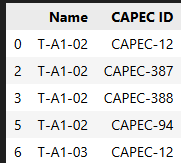

### Large Setup code (GEMINI API)

Connecting to the Google Generative AI API to try larger models
The context window is large, so it can handle the necessary amount of data

In [54]:
large_setup_models = ["gemini-2.5-pro", "gemini-2.5-flash", "gemini-2.5-flash-lite-preview-06-17"]
#models = ["gemini-2.5-flash-lite-preview-06-17"]

In [55]:
def model_inference_gemini(models, df, prompt):
    # Initialize config and client
    config = types.GenerateContentConfig(
        temperature=0.0,
        seed=42
    )
    client = genai.Client()

    model_outputs = {m: [] for m in models}
    model_stats = {m: [] for m in models}

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        for model in models:
            prompt = prompt

            start_time = time.time()
            response = client.models.generate_content(
                model=model,
                contents=prompt,
                config=config
            )
            runtime = time.time() - start_time

            token_count = (
                response.usage_metadata.total_token_count +
                response.usage_metadata.prompt_token_count
            )
            tokens_per_second = token_count / runtime if runtime > 0 else 0

            model_outputs[model].append(response.text)
            model_stats[model].append({
                "runtime": runtime,
                "tokens_per_second": tokens_per_second,
                "token_count": token_count
            })

            tqdm.write(f"Inference for model {model} completed for threat {row['Threat ID']}")

    return model_outputs, model_stats

In [56]:
def display_model_result_gemini(models, model_outputs, model_stats):
    for model in models:
        print("=" * 40)
        print(f"Model: {model}")
        
        # Ensure stats exist
        stat = model_stats.get(model)
        if stat and stat["runtime"] is not None:
            print(f"Speed: {stat['tokens_per_second']:.2f} tokens/second")
            minutes = int(stat["runtime"] // 60)
            seconds = stat["runtime"] % 60
            print(f"Total runtime: {minutes:02d} m {seconds:05.2f} seconds\n")
        else:
            print("Speed: N/A\nTotal runtime: N/A\nTokens: N/A\n")

        print("Output:")
        if model in model_outputs:
            # If multiple outputs exist for this model, iterate over them
            outputs = model_outputs[model]
            if isinstance(outputs, list):
                for output in outputs:
                    cleaned_text = re.sub(r"<think>.*?</think>\s*", "", output, flags=re.DOTALL)
                    display(Markdown(cleaned_text))
            else:
                cleaned_text = re.sub(r"<think>.*?</think>\s*", "", outputs, flags=re.DOTALL)
                display(Markdown(cleaned_text))
        else:
            print("No output available.")

### Zero-Shot Prompt

In [88]:
def create_basic_zero_shot_prompt(threat):
    return f"""Given the following threat summary:
    
    "{threat['summary_th_df']}"
    
    Provide the most relevant CAPEC IDs for this threat based on the description of each CAPEC. CAPEC stands for Common Attack Pattern Enumeration and Classification.
    
    As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. Do not include any additional text or explanations, just the JSON array."""

In [83]:
def create_better_zero_shot_prompt(threat):
    return f"""This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns.

O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open, virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary:

"{threat['summary_th_df'].iloc[0]}"

Provide the most relevant CAPEC IDs for this threat. CAPEC stands for Common Attack Pattern Enumeration and Classification.

As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. Do not include any additional text or explanations, just the JSON array."""

In [ ]:
# Build a formatted string with all CAPEC IDs and their summaries
capec_context = ""

for _, row in capec_data_for_PE.iterrows():
    capec_id = row['CAPEC ID']
    capec_summary = row['summary']
    capec_context += f"{capec_id}: {capec_summary}\n"



In [84]:
def create_prompt_with_capec_list(threat, capec_context):
    return f"""You are a cybersecurity expert.

Here is a list of CAPEC attack pattern summaries:
{capec_context}

Given the following threat description:

"{threat['summary_th_df'].iloc[0]}"

Which 3 CAPEC ID from the list above best match the threat based on their description? Respond only with the CAPEC ID and a brief justification."""


Generating results

In [ ]:
basic_zero = model_inference_ollama(small_models, df, create_basic_zero_shot_prompt)
display_model_results_ollama(small_models, basic_zero)


100%|██████████| 1/1 [00:48<00:00, 48.08s/it]

Inference for model deepseek-r1:1.5b completed for threat T-A1-02. Prompt: Given the following threat summary:

    "A Threat with the title Malicious function or application monitors messaging across A1 interface and the descriptionInternal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy."

    Provide the most relevant CAPEC IDs for this threat based on the description of each CAPEC. CAPEC stands for Common Attack Pattern Enumeration and Classification.

    As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. Do not include any additional text or explanations, just the JSON array.


{'deepseek-r1:1.5b': [GenerateResponse(model='deepseek-r1:1.5b', created_at='2025-07-28T08:10:50.281604536Z', done=True, done_reason='stop', total_duration=48051331988, load_duration=16160277745, prompt_eval_count=120, prompt_eval_duration=2931639318, eval_count=461, eval_duration=28957309016, response='<think>\nOkay, so I need to figure out which CAPEC IDs apply to this threat summary. Let me start by understanding what each CAPEC stands for and how they classify threats.\n\nFirst, the threat is about a malicious function or application monitoring messaging across the A1 interface. The description says it can gain access to messaging for a MiTM attack to read policies. So, the main issue here is unauthorized access to sensitive data through an interface, which leads to a misuse of information.\n\nNow, CAPECs are used to classify threats based on their nature and impact. I remember that there\'s a section in the Common Vulnerability and Exposures database called "Threat Vectors" where 

In [95]:
display_model_results_ollama(small_models, basic_zero)

Model: deepseek-r1:1.5b
Speed: 15.92 tokens/second
Total runtime: 00 m 28.96 seconds

Output:


[
    "70-421"
]

### Few-Shot Prompt

In [200]:
# sort by similarity
sorted_mappings = our_mappings.sort_values(by='Similarity', ascending=False)
sorted_mappings.head(3)

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
116,T-O-RAN-07,enterprise-attack,An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability,CAPEC-268,0.667489,"A Threat with the title An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability and the descriptionImproper / missing controls for protection of security event log files generated by O-RAN components and the lack of security events logged together with a unique system reference (e.g. host name, IP or MAC address) and the exact time the incident occurred do not allow a correct and rapid audit in case of security incident occurrence. Security restoration is delayed. Compromise of availability and integrity of security event log files could conduct to delays, wrong audit results, delays in security restoration, threats persistence.","A CAPEC with the title Audit Log Manipulation. The description of this CAPEC is:The attacker injects, manipulates, deletes, or forges malicious log entries into the log file, in an attempt to mislead an audit of the log file or cover tracks of an attack. Due to either insufficient access controls of the log files or the logging mechanism, the attacker is able to perform such actions.. The Domain of this is: Software"
77,T-RADIO-01,enterprise-attack,"Disruption through radio jamming, sniffing and spoofing",CAPEC-601,0.654919,"A Threat with the title Disruption through radio jamming, sniffing and spoofing and the descriptionLike for any wireless technology, disruption through radio jamming is possible by analyzing the physical downlink and uplink control channels and signals. 5G radio network is vulnerable to:\n• Jamming Vulnerability of Reference Signals\n• Jamming Vulnerability of Synchronization Signal\n• Jamming Vulnerability of the PBCH\n• Sniffing and Spoofing Vulnerability of the PBCH\n• Jamming Vulnerability of PDCCH\n• Jamming Vulnerability of Physical Uplink Control Channel\n• Jamming Vulnerability of Physical Random-Access Channel\nNOTE 1: The O-RAN OEMs need to develop new intelligence that can proactively alert the operator when this attack is initiated so that the operator can take appropriate actions to mitigate.\nNOTE 2: In the scenario of RF spoofing, the UE needs to be able to validate the legitimacy of the O-RU as being one owned and operated by the operator. 3GPP has proposed in a study to use Digital Signatures to mitigate this threat but there has been no agreement on this to date. The O-RAN OEMs need to develop new intelligence that can proactively alert the operator when this attack is initiated so that the operator can take appropriate actions to mitigate.","A CAPEC with the title Jamming. The description of this CAPEC is:An adversary uses radio noise or signals in an attempt to disrupt communications. By intentionally overwhelming system resources with illegitimate traffic, service is denied to the legitimate traffic of authorized users.. The Domain of this is: Communications"
11,T-RADIO-01,enterprise-attack,"Disruption through radio jamming, sniffing and spoofing",CAPEC-605,0.653919,"A Threat with the title Disruption through radio jamming, sniffing and spoofing and the descriptionLike for any wireless technology, disruption through radio jamming is possible by analyzing the physical downlink and uplink control channels and signals. 5G radio network is vulnerable to:\n• Jamming Vulnerability of Reference Signals\n• Jamming Vulnerability of Synchronization Signal\n• Jamming Vulnerability of the PBCH\n• Sniffing and Spoofing Vulnerability of the PBCH\n• Jamming Vulnerability of PDCCH\n• Jamming Vulnerability of Physical Uplink Control Channel\n• Jamming Vulnerability of Physical Random-Access Channel\nNOTE 1: The O-RAN OEMs need to develop new intelligence that can proactively alert the operator when this attack is initiated so that the operator can take appropriate actions to mitigate.\nNOTE 2: In the scenario of RF spoofing,

In [201]:
first_few_shot_example = sorted_mappings.iloc[0]
second_few_shot_example = sorted_mappings.iloc[1]
third_few_shot_example = sorted_mappings.iloc[2]

In [202]:
def create_few_shot_prompt(threat_summary):
    # Build the instruction part
    base_prompt = f"""This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns. O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open, virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary: "{threat_summary}"
Provide the most relevant CAPEC IDs for this threat. CAPEC stands for Common Attack Pattern Enumeration and Classification.

As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described.
Do not include any additional text or explanations, just the JSON array.

Here are some examples:
"""

    # Few-shot examples
    examples = []
    for example in [first_few_shot_example, second_few_shot_example, third_few_shot_example]:
        example_text = f"""
Example:
Threat Name: {example['Name']}
Threat Summary: {example['summary_th_df']}
CAPEC Summary: {example['summary_ca_df']}
Mapped CAPEC ID: {example['CAPEC ID']}
Desired Output:
[{example['CAPEC ID']}]
"""
        examples.append(example_text.strip())

    # Combine everything
    full_prompt = base_prompt + "\n\n".join(examples)
    return full_prompt


## RAG

In [16]:
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

In [19]:
client = chromadb.Client()
client.delete_collection('capec_summaries')
collection = client.create_collection(name="capec_summaries", configuration={'hnsw': {'space': 'cosine'}})

In [20]:
capecs_for_rag = pd.read_pickle('capec_data/capecs_for_rag.pk1')
capecs_for_rag.columns

Index(['CAPEC ID', 'summary_ca_df', 'embedding'], dtype='object')

In [21]:
collection.add(
    documents=capecs_for_rag['summary_ca_df'].tolist(),
    embeddings=capecs_for_rag['embedding'].tolist(),
    ids=capecs_for_rag['CAPEC ID'].astype(str).tolist(),
    metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)

In [22]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

In [24]:
threat_data_for_RAG['summary_th_df'].loc[0]

'A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the descriptionUnauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause 

In [25]:
id_for_query = "T-A1-02"

In [26]:
test_threat = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]

In [27]:
test_threat

,Threat ID,summary_th_df,embedding
82,T-A1-02,A Threat with the title Malicious function or application monitors messaging across A1 interface and the descriptionInternal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"[-0.027739309, 0.039540276, -0.038193483, -0.064284176, 0.088824324, -0.02560193, 0.12704141, 0.065274455, 0.054320317, 0.0046378914, 0.040495235, 0.0023881504, 0.03544273, -0.017115422, 0.016286844, 0.003277275, 0.101387314, -0.021604331, 0.018275477, 0.064627446, 0.08360575, 0.09084395, 0.023560043, -0.048624154, -0.06993853, -0.057262607, -0.04224992, 0.0016884137, 0.0075714597, -0.033969115, -0.06429448, 0.060686, -0.021285363, 0.053470537, -0.0606143, 0.033483386, 0.044285163, -0.02340873, -0.059319247, -0.057974245, -0.016330019, 0.07626063, 0.017759696, 0.022122798, -0.04441153, -0.06288382, -0.037837766, 0.04278041, -0.081336096, -0.04566745, -0.034063447, -0.037952803, 0.033880893, 0.06803568, 0.047451872, 0.00011087, 0.02009153, 0.07239538, 0.003620003, 0.060912747, 0.0074188113, -0.024893595, -7.6623866e-05, -0.009235851, -0.004327226, 0.017078962, -0.029751316, 0.029763315, 0.0029225426, -0.013260386, -0.069189, -0.039105035, -0.091323, 0.017978434, 0.028634576, 0.12855332, -0.049613547, -0.029881166, -0.018157825, -0.022697724, -0.018072657, 0.020875853, -0.019673185, 0.07867883, -0.014780375, 0.045998853, -0.021762995, -0.09158808, 0.04431891, 0.038917635, 0.0010569671, -0.08731048, 0.08533341, 0.06907569, 0.028410776, 0.048127726, -0.068348385, -0.13235407, -0.037798945, 0.12500024, ...]"


In [28]:
def get_relevant_informations(threat, db, n_results=3):
    query = threat['summary_th_df']
    embedding = threat['embedding']
    results = db.query(
        query_texts=[query],
        query_embeddings=[embedding],
        n_results=n_results
    )
    return results



In [29]:
relevant_infos = get_relevant_informations(test_threat.iloc[0], collection, 10)

In [30]:
for doc, meta, score in zip(
    relevant_infos['documents'][0],
    relevant_infos['metadatas'][0],
    relevant_infos['distances'][0]
):
    print("Text:", doc)
    print("Metadata:", meta)
    print("Similarity Score:", round(score, 4))
    print("-" * 40)

Text: A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
Metadata: {'CAPEC ID': 'CAPEC-387'}
Similarity Score: 0.3901
----------------------------------------
Text: A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an

In [31]:
for meta, score in zip(relevant_infos['metadatas'][0], relevant_infos['distances'][0]):
    print("Metadata:", meta)
    print("Similarity Score:", round(1-score, 4))
    print("-" * 40)


Metadata: {'CAPEC ID': 'CAPEC-387'}
Similarity Score: 0.6099
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-12'}
Similarity Score: 0.5907
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-388'}
Similarity Score: 0.5831
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-502'}
Similarity Score: 0.5569
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-94'}
Similarity Score: 0.554
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-272'}
Similarity Score: 0.5522
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-41'}
Similarity Score: 0.5457
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-499'}
Similarity Score: 0.5432
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-505'}
Similarity Score: 0.5419
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-134'}
Similarity Score: 0.5296
-------------------------

In [2]:
threat2capec_mapping_df = pd.read_pickle('mapped_data/all_t2c_mappings.pk1')
threat2capec_mapping_df.columns

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object')

In [3]:
threat2capec_mapping_df.shape

(101738, 7)

In [34]:

comparison = threat2capec_mapping_df[threat2capec_mapping_df.Name == id_for_query]

In [35]:
comparison[['CAPEC ID', 'Similarity']].sort_values('Similarity', ascending=False).head(5)

,CAPEC ID,Similarity
26472,CAPEC-387,0.609855
85622,CAPEC-12,0.590688
60506,CAPEC-388,0.583051
70334,CAPEC-502,0.556925
21558,CAPEC-94,0.553981


51


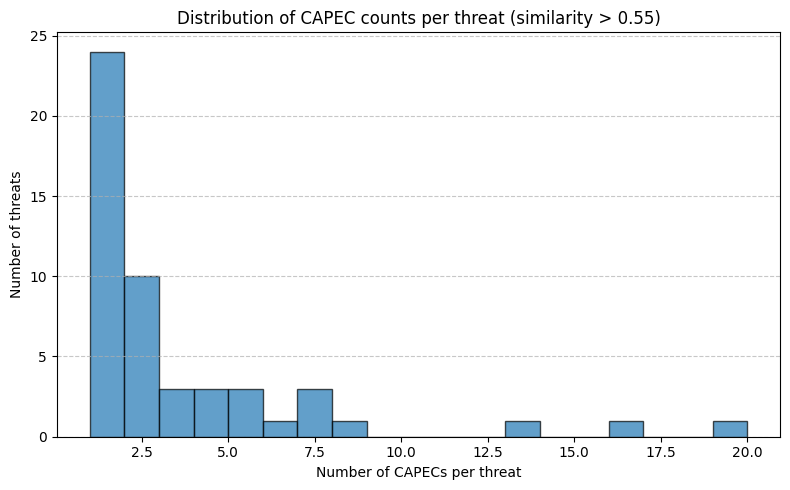

In [4]:
import matplotlib.pyplot as plt

# Filter by similarity
filtered_df = threat2capec_mapping_df[threat2capec_mapping_df["Similarity"] > 0.55]

# Count CAPECs per threat
capec_counts = filtered_df.groupby("Name")["CAPEC ID"].nunique()
print(len(capec_counts))
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(capec_counts, bins=range(1, capec_counts.max() + 2), edgecolor='black', alpha=0.7)
plt.title("Distribution of CAPEC counts per threat (similarity > 0.55)")
plt.xlabel("Number of CAPECs per threat")
plt.ylabel("Number of threats")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [7]:
filtered_df.Similarity.describe()

count    163.000000
mean       0.577498
std        0.025743
min        0.550371
25%        0.557160
50%        0.569874
75%        0.589652
max        0.667489
Name: Similarity, dtype: float64

In [37]:
threat2capec_mapping_df[threat2capec_mapping_df['Name'] == "T-rAPP-06"]['summary_th_df'].values[0]

'A Threat with the title An attacker bypasses authentication and authorization using an injection attack and the descriptionIt is possible that an attacker to submit requests without prior authentication and authorization by executing an injection attack to manipulate configurations, access logs, perform remote code execution, etc.'

In [38]:
capec_counts.describe()

count    51.000000
mean      3.196078
std       3.810615
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      19.000000
Name: CAPEC ID, dtype: float64

In [39]:
capec_counts.median()

np.float64(2.0)

In [40]:
import numpy as np

In [41]:
percentile_for_10 = (np.sum(capec_counts <= 10) / len(capec_counts)) * 100
print(f"10 corresponds to approximately the {percentile_for_10:.2f}th percentile.")

10 corresponds to approximately the 94.12th percentile.


In [42]:
cosine_similarity = util.pytorch_cos_sim(
    torch.from_numpy(test_threat['embedding'].iloc[0]),
    torch.from_numpy(capecs_for_rag[capecs_for_rag['CAPEC ID'] == 'CAPEC-94']['embedding'].iloc[0])
)
cosine_similarity

tensor([[0.5540]])

In [ ]:
def create_rag_prompt(threat):
    n_results = 10
    results = get_relevant_informations(threat, collection, n_results=n_results)

    # Prepare CAPEC list with IDs and summaries
    capec_entries = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        capec_id = meta.get("CAPEC ID", "N/A")
        capec_entries.append(f"{capec_id}: {doc}")

    capec_information = "\n".join(capec_entries)
    threat_description = threat['summary_th_df']

    # Build the RAG prompt
    prompt = f"""
This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns.
O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open,
virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future
generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary:
{threat_description}

Additionally, consider the following list of candidate CAPEC entries that were retrieved from a vector database as the 20
most similar attack patterns to the given threat summary:

{capec_information}

From this list, identify which CAPEC IDs are most relevant to the described threat.

As an output, provide only a JSON array containing the selected CAPEC IDs.
Do not include any explanations or additional text, only the JSON array.
"""
    return prompt.strip()


In [49]:
small_models

['deepseek-r1:1.5b']

In [63]:
rag_test = model_inference_ollama(small_models, test_threat, create_rag_prompt)

100%|██████████| 1/1 [01:07<00:00, 67.59s/it]

Inference for model deepseek-r1:1.5b completed for threat T-A1-02


In [65]:
display_model_results_ollama(small_models, rag_test)

Model: deepseek-r1:1.5b
Speed: 14.33 tokens/second
Total runtime: 01 m 06.85 seconds

Output:


```json
[
  "CAPEC-12",
  "CAPEC-388",
  "CAPEC-502",
  "CAPEC-272",
  "CAPEC-41",
  "CAPEC-499"
]
```

In [68]:
medium_models = ['deepseek-r1:8b']

In [70]:
rag_test_medium = model_inference_ollama(medium_models, test_threat, create_rag_prompt)

100%|██████████| 1/1 [06:29<00:00, 389.86s/it]

Inference for model deepseek-r1:8b completed for threat T-A1-02


In [71]:
display_model_results_ollama(medium_models, rag_test_medium)

Model: deepseek-r1:8b
Speed: 3.70 tokens/second
Total runtime: 03 m 24.75 seconds

Output:


["CAPEC-94", "CAPEC-502"]

## Fine Tuning with LoRA

In [9]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments
from trl import SFTTrainer
import wandb


/tmp/ipykernel_3837/4019501768.py:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [14]:
wnb_token = os.getenv("WNB_TOKEN")

In [ ]:
wandb.login(key=wnb_token)
run = wandb.init(
    project="capec-mapping",
    job_type="training",
    anonymous="allow",
        )
    # config={
    #     "model_name": "deepseek-r1:8b",
    #     "dataset": "mapped_data/lora_training_data.jsonl",
    #     "batch_size": 4,
    #     "learning_rate": 2e-5,
    #     "num_train_epochs": 3,
    #     "gradient_accumulation_steps": 1,
    #     "logging_steps": 10,
    #     "save_steps": 1000,
    # 



SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' on line 2 (651126383.py, line 16)

In [12]:
import json

file_path = 'mapped_data/lora_training_data.jsonl'

# Use a list comprehension to load each line as a separate JSON object
data = [json.loads(line) for line in open(file_path, 'r', encoding='utf-8')]

# 'data' is now a list of dictionaries, one for each line in your file.
pprint(data[0]) # To see the first item

{'capec_id': 'CAPEC-533',
 'mapped_capec': 'A CAPEC with the title Malicious Manual Software Update. The '
                 'description of this CAPEC is:An attacker introduces '
                 "malicious code to the victim's system by altering the "
                 'payload of a software update, allowing for additional '
                 'compromise or site disruption at the victim location. These '
                 'manual, or user-assisted attacks, vary from requiring the '
                 'user to download and run an executable, to as streamlined as '
                 'tricking the user to click a URL. Attacks which aim at '
                 'penetrating a specific network infrastructure often rely '
                 'upon secondary attack methods to achieve the desired impact. '
                 'Spamming, for example, is a common method employed as an '
                 'secondary attack vector. Thus the attacker has in their '
                 'arsenal a choice of initial at

# Evaluation